# Convert and Optimize RAFT with OpenVINO™

The Recurrent All-Pairs Field Transforms (RAFT) [repository](https://github.com/princeton-vl/RAFT) is a new deep network architecture for optical flow. 

RAFT extracts perpixel features, builds multi-scale 4D correlation volumes for all pairs of pixels, and iteratively updates a flow field through a recurrent unit that performs lookups on the correlation volumes. RAFT achieves stateof-the-art performance.

This tutorial demonstrates step-by-step instructions on how to run and optimize RAFT with OpenVINO based on the [ONNX-RAFT-Optical-Flow-Estimation](https://github.com/ibaiGorordo/ONNX-RAFT-Optical-Flow-Estimation/tree/main). 

The tutorial consists of the following steps:
- Download ONNX model
- Convert ONNX model to OpenVINO IR
- Prepare and run optimization pipeline
- Visualize the flow image
- Evaluate the performance.

Download the ONNX model from the [PINTO_model_zoo](https://github.com/PINTO0309/PINTO_model_zoo/tree/04f86a550e2ce1c5fb70cfafdfdeb568700f61c2/252_RAFT). 
The original PyTorch models were converted to ONNX models with different input sizes and iteration times.

Here we will convert the raft_kitti_iter20_480x640 model.

In [1]:
import sys
sys.path.append("../utils")
import notebook_utils as utils
import tarfile
from pathlib import Path

base_model_dir = Path("models")

model_name = "iter20"

archive_name = "resources.tar.gz"

model_url = f"https://s3.ap-northeast-2.wasabisys.com/pinto-model-zoo/252_RAFT/{model_name}/{archive_name}"

downloaded_model_path = base_model_dir / Path(archive_name)

if not downloaded_model_path.exists():
    utils.download_file(model_url, downloaded_model_path.name, downloaded_model_path.parent)

model_onnx_path= base_model_dir / Path('raft_kitti_iter20_480x640.onnx')

if not model_onnx_path.exists():
    with tarfile.open(downloaded_model_path) as file:
        file.extractall(base_model_dir)

Convert model to OpenVINO IR.

In [2]:
import subprocess

model_ov_path = model_onnx_path.with_suffix(".xml")

if not model_ov_path.exists():
    # Run Model Optimizer to convert ONNX model to OpenVINO IR.
    mo_command = f'mo --framework onnx -m {model_onnx_path} --output_dir {base_model_dir}'
    subprocess.call(mo_command, shell=True) 
else: print('OpenVINO IR already converted')

OpenVINO IR already converted


Load the model.

In [3]:
from openvino.runtime import Core

core = Core()
core.set_property({'CACHE_DIR': '.cache'})

model_ov = core.read_model(model=model_ov_path)
compiled_model = core.compile_model(model=model_ov, device_name="CPU")
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(1)

print(f"input precision: {input_layer.element_type}")
print(f"input shape: {input_layer.shape}")
N, C, H, W = input_layer.shape
print(f"output precision: {output_layer.element_type}")
print(f"output shape: {output_layer.shape}")

input precision: <Type: 'float32'>
input shape: [1,3,480,640]
output precision: <Type: 'float32'>
output shape: [1,2,480,640]


Download and prepare two KITTI frames.

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def prepare_input(img):
    # plt.imshow(img)
    # plt.show()
    img_input = cv2.resize(img, (W, H))
    img_input = img_input.transpose(2, 0, 1)
    img_input = img_input[np.newaxis,:,:,:]      

    return img_input.astype(np.float32)


IMAGE_PATH_1 = "../data/image/kitti_1.png"
IMAGE_PATH_2 = "../data/image/kitti_2.png"

if not Path(IMAGE_PATH_1).exists():
    !wget https://raw.githubusercontent.com/liruoteng/OpticalFlowToolkit/master/data/example/KITTI/frame1.png -O ../data/image/kitti_1.png
    !wget https://raw.githubusercontent.com/liruoteng/OpticalFlowToolkit/master/data/example/KITTI/frame2.png -O ../data/image/kitti_2.png

img1 = np.array(Image.open(IMAGE_PATH_1), dtype=np.uint8)
img2 = np.array(Image.open(IMAGE_PATH_2), dtype=np.uint8)

img_height, img_width = img1.shape[:2]
input_tensor1 = prepare_input(img1)
input_tensor2 = prepare_input(img2)


Do Inference

In [5]:
result = compiled_model([input_tensor1, input_tensor2])[output_layer]
flow_map_ov = result[0].transpose(1, 2, 0)

Utils function for transfering flow to image from OpticalFlowToolkit

In [6]:
# Ref: https://github.com/liruoteng/OpticalFlowToolkit/blob/5cf87b947a0032f58c922bbc22c0afb30b90c418/lib/flowlib.py#L249
UNKNOWN_FLOW_THRESH = 1e7

def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

colorwheel = make_color_wheel()

def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img

def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)


Visualize the flow image and arrow image with matplotlib quiver.

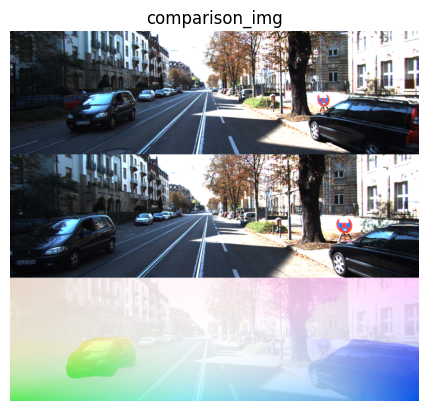

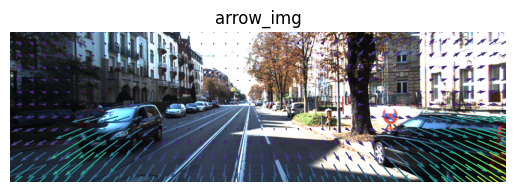

In [7]:
def draw_flow(flow_map):
    flow_img = flow_to_image(flow_map)
    flow_img = cv2.cvtColor(flow_img, cv2.COLOR_RGB2BGR)
    return cv2.resize(flow_img, (img_width, img_height))

def draw_arrow(origin_img, flow_map):
    flow_img = cv2.resize(flow_map, (img_width, img_height)) 
    num = 30 
    x, y = np.meshgrid(np.arange(0, img_height, num, dtype=int), 
                       np.arange(0, img_width, num, dtype=int))
    u = flow_img[:,:,0]
    v = flow_img[:,:,1]
    U = u[x,y]
    V = -v[x,y]

    plt.imshow(origin_img)
    plt.quiver(y,x,U,V,np.hypot(U, V))
    plt.title('arrow_img')
    plt.axis('off')
    plt.show()

def draw_comparison_img(img1, img2, flow_img):
    alpha = 0.1
    combined_img = cv2.addWeighted(img1, alpha, flow_img, (1-alpha),0)

    comparison_img = np.vstack((img1, img2, combined_img))
    
    plt.imshow(comparison_img)
    plt.title('comparison_img')
    plt.axis('off')
    plt.show()


flow_img_ov = draw_flow(flow_map_ov)

draw_comparison_img(img1, img2, flow_img_ov)

draw_arrow(img1, flow_map_ov)

Use the OpenVINO [Benchmark Tool](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html) to measure the inference performance on CPU. 

In [8]:
!benchmark_app -m {model_ov_path} -d CPU -niter 5

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 387.59 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     0 (node: 0) : f32 / [...] / [1,3,480,640]
[ INFO ]     1 (node: 1) : f32 / [...] / [1,3,480,640]
[ INFO ] Model outputs:
[ INFO ]     23437 (node: 23437) : f32 / [...] / [1,2,60,80]
[ INFO ]     23436 (node: 23436) : f32 / [...] / [1,2,480,640]
[Step 5/11] Resizing mo

### References
1. RAFT: Recurrent All Pairs Field Transforms for Optical Flow (https://arxiv.org/pdf/2003.12039.pdf)
2. ONNX-RAFT-Optical-Flow-Estimation: https://github.com/ibaiGorordo/ONNX-RAFT-Optical-Flow-Estimation/tree/main 

ONNX-RAFT-Optical-Flow-Estimation used in this notebook licensed under the MIT License. The license is displayed below: <br>
MIT License

Copyright (c) 2022 Ibai Gorordo

Permission is hereby granted, free of charge, to any person obtaining a copy<br>
of this software and associated documentation files (the "Software"), to deal<br>
in the Software without restriction, including without limitation the rights<br>
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell<br>
copies of the Software, and to permit persons to whom the Software is<br>
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all<br>
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR<br>
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,<br>
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE<br>
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER<br>
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,<br>
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE<br>
SOFTWARE.